In [1]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 80
import seaborn as sns
import pandas as pd
import numpy as np
import math
import statistics
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit

def objective(x, a, b, c):
    return a * x + b * x**2 + c

def c_of_c_test(r, n, a):
    t_value = r * ((n-2)/(1 - r**2)) ** 0.5
    t_critical = stats.t.ppf(1 - a/2, n - 2)
    pval = stats.t.sf(np.abs(t_value), n - 2)*2
    print('r = ', r)
    print('t_critical = ', t_critical)
    print('t = ', t_value)
    print('p_value = ', pval)
    return t_value

def CI_simple_regression(df,x, y, x1, a):
    x_new = np.array([1, x1])
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    #point prediction value
    y_head = np.dot(df.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core1 = (1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) /    cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core1
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core1
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core1
    CI = np.array([lower_bound, upper_bound])
    print(f"{100*(1-a)}%% confidence interval for mean: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    return CI

def PI_simple_regression(df,x, y, x1, a):
    x_new = np.array([1, x1])
    print("make prediction at new x = ", x1)
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    y_head = np.dot(df.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core2 = (1 + 1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core2
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core2
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core2
    PI = np.array([lower_bound, upper_bound])
    print(f"{100*(1-a)}%% prediction interval: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    return PI

def Chi_Square_for_Normality(SD, N, a): 
    m = np.mean(SD)
    s = np.std(SD)   
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s 
    counts, bins = np.histogram(SD, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
        chi_pval = -99999 # Invalid
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e) 
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
#         print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = N - 3
    crit_value = stats.chi2.ppf(1 - a, df)
#     print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    return chi_pval


def Randomness(SD):
    print('Randomness Test using Runs Test')
    print(' - H0: Randomness exists.')
    print(' - H1: Randomness does not exist\n')
    
    SD_median = statistics.median(SD)
    
    runs, n1, n2 = 1, 0, 0
    if(SD[0]) >= SD_median:
        n1 += 1   
    else:
        n2 += 1     
    # Checking for start of new run 
    for i in range(1,len(SD)): 
        # no. of runs 
        if (SD[i] >= SD_median and SD[i-1] < SD_median) or (SD[i] < SD_median and SD[i-1] >= SD_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(SD[i]) >= SD_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    if n1>20 or n2>20:
        print('\nruns_exp = ', runs_exp)
        print('stan_dev = ', stan_dev)
        print('z = ', z)
        print('pval_z = ', pval_z)
        
        if pval_z < 0.05:
            print('\nSince p-value < 0.05, we reject H0 and conclude randomness does not exist.')
        else:
            print('\nSince p-value > 0.05, we do not reject H0 and we may conclude randomness exists.')
    else:
        print('Since both n1 and n2 < 20, we check the Run Test table.')
def Homoscedasticity(data, xlabel):
    print('Homoscedasticity Test')
    print(' - H0: Homoscedasticity')
    print(' - H1: Heteroscedasticity\n')
    y_pre = data[:, 2]
    SD = data[:, 10]
    plt.plot(y_pre, SD, 'o', color = 'gray')
    plt.axhline(y=0, color = 'blue')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.title('Standardized Residual Plot')
    plt.xlabel(xlabel)
    plt.ylabel('Standardized Residual')
    plt.show()

def Normality(SD):
    print('Normality test for errors using Shapiro Test or Chi-square Test')
    print(' - H0: Errors are normally distributed.')
    print(' - H1: Errors are not normally distributed.\n')
    stat, p = stats.shapiro(SD)
    chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
    print('pvalue of Chi square =', chi2_pval)
    print('pvalue of Shapiro Test =', p)
    if p > 0.05:
        print('\nSince p-value (shapiro) > 0.05, we do not reject H0 and we may conclude errors are normally distributed.')
    elif chi2_pval > 0.05:
         print('\nSince p-value (chi square) > 0.05, we do not reject H0 and we may conclude errors are normally distributed.')
    else:
        print('\nSince p-value < 0.05, we reject H0 and conclude errors are not normally distributed.')

def Outlier(SD):
    df = pd.DataFrame(SD,columns = ['SD'])
    filter = (df['SD'] < -2) | (df['SD'] > 2)
    outliers = df['SD'].loc[filter]
    ids = outliers.index
    ids = [n+1 for n in ids]
    
    print("Outliers by SD = \n")
    print(outliers)
    
    if len(ids)== 0:
        print("\nThere isnt any oulier.")
    else:
        print("\nSample", ids, "are outliers.")
        
def Influential(x_data, y_data):
    x_data = x_data.values
    y_data = y_data.values
    cov_mat = np.cov(y_data, x_data)
    x_data_bar = x_data.mean()
    data_nobs = len(x_data)
    h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat[1,1]
    df = pd.DataFrame(h_val,columns = ['hi'])
    filter = (df['hi'] > 6 / data_nobs )
    influs = df['hi'].loc[filter]
    ids = influs.index
    ids = [n+1 for n in ids]
    
    print("Influential Observations by hi = \n")
    print(influs)
    
    if len(ids)== 0:
        print("\nThere isnt any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")

def CI_PI_regression(xdata, yval, x1, a):
    print("make CI and PI prediction at mean of x = ", x1)
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5
    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    print("confidence interval of mean = [%0.4f, %0.4f] " % (lower_bound, upper_bound))
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
    CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
    return CI_PI

def Durbin_Watson_test(x,dl,du):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print(f"According to table of Durbin-Watson test, dL is {dl}, dU is {du}. d is {d:.4f}.")
    print("\nConduct Autocorrelation test")
    print("H0: The data are not positively first-order correlated.")
    print("H1: The data are positively first-order correlated.\n")
    if d < dl:
        print("d < dL. H0 is rejected.There is enough evidence to show that positive first-order correlation exists.")
    elif d > du:
        print("d > dU. H0 is not rejected.There is not enough evidence to show that positive first-order correlation exists.")
    elif (d > dl and d <du):
        print("The test is inconclusive.")
    print("\nH0: The data are not negatively first-order correlated.")
    print("H1: The data are negatively first-order correlated.\n")
    if d > 4-dl:
        print("d > 4 - dL. H0 is rejected.There is enough evidence to show that negative first-order correlation exists.")
    elif d < 4-du:
        print("d < 4 - dU. H0 is not rejected.There is not enough evidence to show that negative first-order correlation exists.")
    elif (d < 4 - dl and d  > 4 - du):
        print("The test is inconclusive.")

def Model_Assess(result_reg, ydata, ylabel):
    print("Check Standard error")
    print("standard error = ", result_reg.mse_resid ** 0.5)
    print("mean of y", ydata.mean())
    print("std of y", ydata.std())
    
    print("\n Check R-squared")
    print("R-squared = ", result_reg.rsquared)
    print("Adjusted R-squared = ", result_reg.rsquared_adj)
    print(f"{result_reg.rsquared*100:.4f}% of variation in {ylabel} is explained by the variations in independent variables. The rest remains unexplained.")
    if(result_reg.rsquared - result_reg.rsquared_adj < 0.06):
        print("The gap between R-squared and Adjusted R-squared is smaller than 0.06, The model is fine.")
    else:
        print("The gap between R-squared and Adjusted R-squared is bigger than 0.06, There may be overfitting.")
    
    print("\n Conduct F test")
    f_res = result_reg.fvalue
    print("F value = ", f_res)
    MSE = result_reg.mse_resid
    df_model = result_reg.df_model
    df_error = result_reg.df_resid
    MSR = f_res * MSE
    SSR = MSR * df_model
    print("SSR = ", SSR, "df = ", df_model, "MSR = ", MSR)
    print("SSE = ", MSE * df_error, "df = ", df_error, "MSE = ", MSE)
    print("F = ", MSR / MSE)
    A = np.identity(len(result_reg.params))
    A = A[1:,:]
    print("F test = ", result_reg.f_test(A))
    print("F p-value = ", result_reg.f_pvalue)
    if( result_reg.f_pvalue < 0.05):
        print("Since p-value is smaller than 0.05, H0 is rejected. The model is valid.")
    else:
        print("Since p-value is bigger than 0.05, H0 is not rejected. The model is not valid.")
    
    print("\n Conduct T test")
    to_t = result_reg.pvalues.reset_index()
    for i in range(1,len(to_t)):
        if to_t[0][i] < 0.05:
            print(f"The pvalue of {to_t['index'][i]} is smaller than 0.05, H0 is rejected. {to_t['index'][i]} is related to {ylabel}")
        else:
            print(f"The pvalue of {to_t['index'][i]} is bigger than 0.05, H0 is not rejected. {to_t['index'][i]} is not related to {ylabel}")
def Print(result_reg):
    To_Print = result_reg.params.reset_index()
    print("Estimated model: y = ", end='')
    for i in range(len(To_Print)):
        if i == 0:
            print(f"{To_Print[0][i]:.4f}", end='')
        else:
            if To_Print[0][i] >= 0:
                print(" + ", end='')
            else:
                print(" ", end='')
            print(f"{To_Print[0][i]:.4f} {To_Print['index'][i]}", end='')
    
def forward_selection(input_df, depv="y", indepv = ["x1"]):
    selected = []
    candidates = indepv.copy()
    best_adjr2 = -1
    best_subset = []
    while len(candidates) > 0:
        print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []
        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            modelstr = depv + " ~ " + "+".join(tmplist)
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]
        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")
        print("===============")
        print("Current best model: ", selected)
        print("Current best AdjR2: ", this_adjr2)
        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected
        candidates = set(candidates) - set(selected)
        candidates = list(candidates)
    print("best_adjr2 = ", best_adjr2)
    print("best_subset = ", best_subset)
    modelstr = depv + " ~ " + "+".join(best_subset)
    result6b = smf.ols(modelstr, data=input_df).fit()
    print(result6b.summary()) 
    
def influential_multi(X_data,df,data):
    # hi 
    X = np.array(X_data)
    H = np.matmul(X, np.linalg.solve(np.matmul(X.T, X), X.T))
    df['hii'] = np.diagonal(H)
    df_h = pd.DataFrame(df['hii'])
    k = result_reg.df_model
    n = len(df_h['hii'])
    h_level = 3 * (k+1) / n 
    print("h_level = ", h_level)
    print(" \n")
    filter = (df_h['hii'] > h_level )
    influs = df_h['hii'].loc[filter]
    print("Influential Observations by hi = \n")
    print(influs)
    ids = influs.index
    ids = [n+1 for n in ids]
    
    if len(ids)== 0:
        print("\nThere isnt any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")

    # cooks
    s2_e = result_reg.mse_resid
    k = result_reg.df_model
    y_a = data[:, 1]
    y_f = data[:, 2]
    h_i = df['hii']
    CD_arr = np.square(y_a - y_f) / s2_e / (k - 1) * h_i / np.square(1 - h_i)
    CD = np.array(CD_arr)
    df_cd = pd.DataFrame(CD,columns = ['CD'])
    display(df_cd.head())
    filter = (df_cd['CD'] > 1 )
    influs = df_cd['CD'].loc[filter]
    print("Influential Observations by Cook's Distances = \n")
    print(influs)
    ids = influs.index
    ids = [n+1 for n in ids]
    
    if len(ids)== 0:
        print("\nThere isn't any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")
def value_to_int(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return int(float(x.replace('K', '')) * 1000)
        return 1000
    if 'M' in x:
        if len(x) > 1:
            return int(float(x.replace('M', '')) * 1000000)
        return 1000000
    if 'B' in x:
        return int(float(x.replace('B', '')) * 1000000000)
    if ' ' in x:
        return int(float(x.replace(' ','')))
    return int(x)
def value_to_ln(x):
    return np.log(x)



=================================== Avg_Daily_Visitors - Facebook_likes ===================================




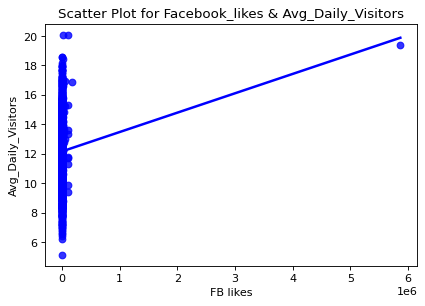

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     12.16
Date:                Sat, 21 May 2022   Prob (F-statistic):           0.000502
Time:                        17:56:54   Log-Likelihood:                -3282.6
No. Observations:                1483   AIC:                             6569.
Df Residuals:                    1481   BIC:                             6580.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.1683      0.058    211.

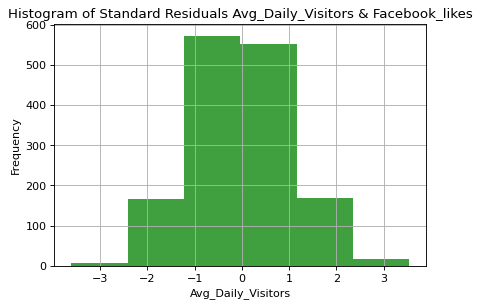

Shapiro Test
Statistics=0.998, p=0.113
Chi-squared test:
0.01521829406332747


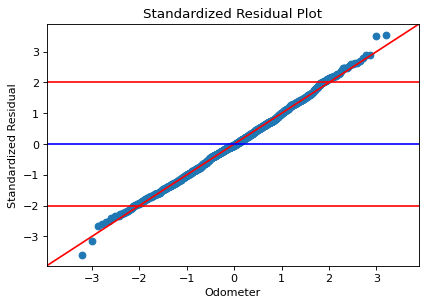

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  432
n1 =  742
n2 =  741

runs_exp =  742.4996628455833
stan_dev =  19.248363414968605
z =  -16.131224050150745
pval_z =  1.5393894411504217e-58

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       3.508525
1       3.548468
2      -3.613585
3       2.811662
5       2.901787
          ...   
1300   -2.058527
1347   -2.270753
1443   -2.341511
1457   -3.173485
1481   -2.684404
Name: SD, Length: 74, dtype: float64

Influential Observations 

[9.03595271e-04 6.76298160e-04 9.96563195e-01 ... 6.75094771e-04
 6.75094470e-04 6.75094168e-04]
Influential Observations by hi = 

2    0.996563
Name: hi, dtype: float64
MSE:  4.905872910963007
Standard errors:  2.2149205202361113


Coefficient of determination:

SSR =  7265.597781136214
R2 =  0.008144799702907712


Coefficient of correlation:

r =  0.09024854404868779
t_critical =  1.961567075831078
t = 

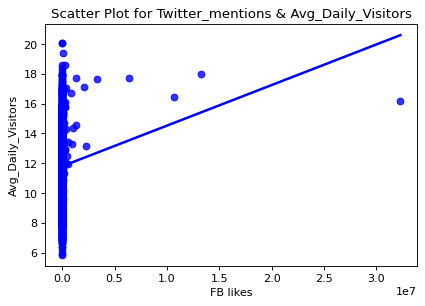

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     20.19
Date:                Sat, 21 May 2022   Prob (F-statistic):           7.38e-06
Time:                        17:56:54   Log-Likelihood:                -4683.5
No. Observations:                2093   AIC:                             9371.
Df Residuals:                    2091   BIC:                             9382.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.7973      0.050  

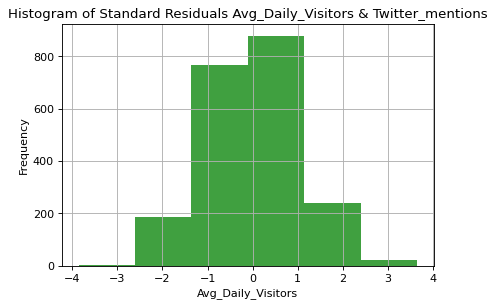

Shapiro Test
Statistics=0.996, p=0.000
Chi-squared test:
0.0409610907351477


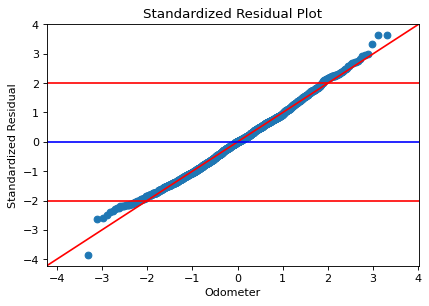

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  548
n1 =  1047
n2 =  1046

runs_exp =  1047.4997611084568
stan_dev =  22.86918541631109
z =  -21.84160703652332
pval_z =  9.341132406932905e-106

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       3.641362
1       3.633344
2       3.350390
3       2.918083
6       2.996488
          ...   
1804   -2.024667
1944   -2.071263
1947   -2.112050
1954   -2.283089
2021   -2.014948
Name: SD, Length: 95, dtype: float64

Influential Observations 

[0.0004784  0.0004782  0.00047819 ... 0.00047896 0.00047896 0.00047895]
Influential Observations by hi = 

15      0.008107
17      0.125970
26      0.029435
93      0.003534
174     0.743298
394     0.003962
1061    0.081580
Name: hi, dtype: float64
MSE:  5.147247088723337
Standard errors:  2.268754523681074


Coefficient of determination:

SSR =  10762.893662520499
R2 =  0.009564765978763545


Coefficie

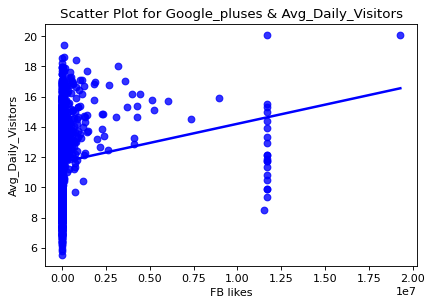

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     46.67
Date:                Sat, 21 May 2022   Prob (F-statistic):           1.03e-11
Time:                        17:56:55   Log-Likelihood:                -6189.4
No. Observations:                2807   AIC:                         1.238e+04
Df Residuals:                    2805   BIC:                         1.239e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.6745      0.042    279.019

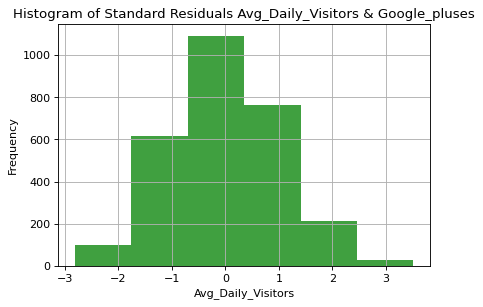

Shapiro Test
Statistics=0.997, p=0.000
Chi-squared test:
0.02148725234481718


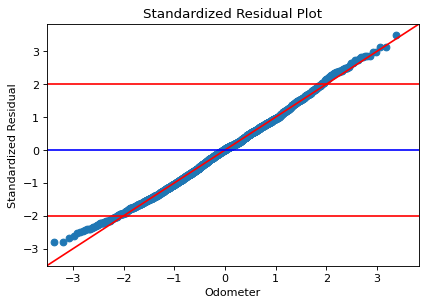

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  753
n1 =  1404
n2 =  1403

runs_exp =  1404.4998218738867
stan_dev =  26.4858402316993
z =  -24.598042432278437
pval_z =  1.3256030085797327e-133

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       2.521606
2       3.511218
3       2.979620
6       3.137677
8       2.811108
          ...   
2647   -2.351948
2653   -2.204539
2725   -2.382020
2726   -2.026164
2758   -2.065533
Name: SD, Length: 127, dtype: float64

Influential Observations 

[0.03815619 0.10431389 0.0003565  ... 0.00036319 0.00036317 0.00036319]
Influential Observations by hi = 

0       0.038156
1       0.104314
114     0.010109
116     0.007289
133     0.003681
219     0.007658
221     0.004525
226     0.002748
301     0.022291
318     0.003001
628     0.038156
745     0.038156
855     0.005156
980     0.038156
1094    0.015117
1141    0.005513
1171    0.038156
1224    0.

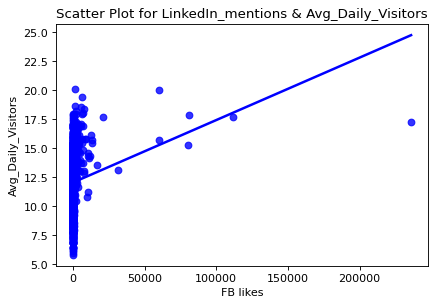

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     57.21
Date:                Sat, 21 May 2022   Prob (F-statistic):           5.85e-14
Time:                        17:56:56   Log-Likelihood:                -4553.4
No. Observations:                2081   AIC:                             9111.
Df Residuals:                    2079   BIC:                             9122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.0364      0.04

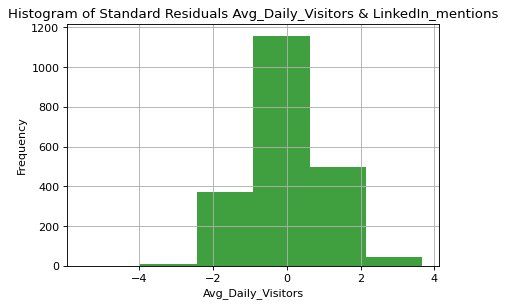

Shapiro Test
Statistics=0.997, p=0.000
Chi-squared test:
0.0016267436683217638


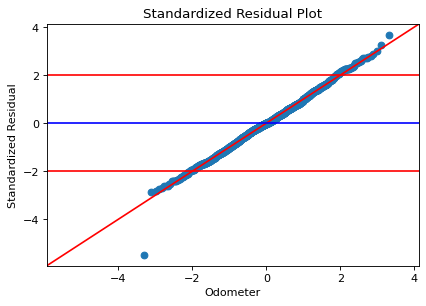

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  578
n1 =  1041
n2 =  1040

runs_exp =  1041.4997597308986
stan_dev =  22.80350059834276
z =  -20.325816105821197
pval_z =  7.601451322528516e-92

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       3.675643
1       2.256901
2       3.263396
3       2.769588
6       3.007270
          ...   
1960   -2.330486
1967   -2.559652
2026   -2.228297
2028   -2.372274
2078   -2.694827
Name: SD, Length: 104, dtype: float64

Influential Observations 

[0.00049181 0.03874921 0.00081865 ... 0.00048401 0.00048508 0.00048509]
Influential Observations by hi = 

1       0.038749
8       0.070448
17      0.005113
19      0.602273
28      0.135188
115     0.039137
397     0.010954
1073    0.069579
1683    0.003244
Name: hi, dtype: float64
MSE:  4.660868206544819
Standard errors:  2.158904399584386


Coefficient of determination:

SSR =  9689.945001406679
R2 =

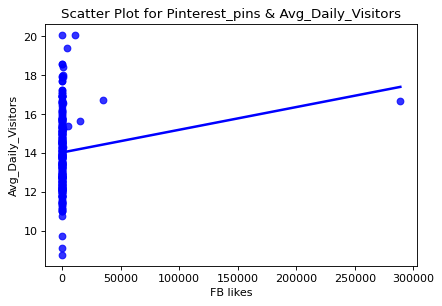

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.156
Date:                Sat, 21 May 2022   Prob (F-statistic):             0.0768
Time:                        17:56:56   Log-Likelihood:                -536.53
No. Observations:                 260   AIC:                             1077.
Df Residuals:                     258   BIC:                             1084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.0227      0.119    117.

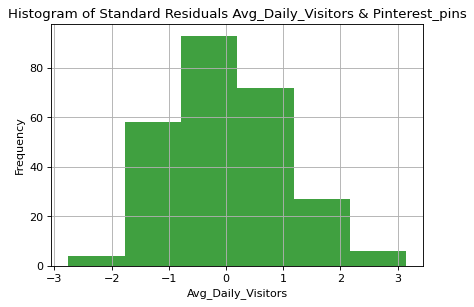

Shapiro Test
Statistics=0.985, p=0.009
Chi-squared test:
0.28748545119250213


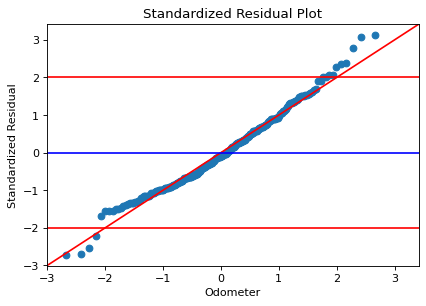

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  86
n1 =  130
n2 =  130

runs_exp =  131.0
stan_dev =  8.04667849171537
z =  -5.5923695778737414
pval_z =  2.239913984596874e-08

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0      3.097897
1      3.153331
2      2.798959
3      2.298910
5      2.394566
11     2.072306
41     2.038357
42    -2.741739
105    2.383278
106    2.067656
107    2.022116
142   -2.251395
160   -2.758284
220   -2.576774
Name: SD, dtype: float64

Influential Observations 

[0.00488826 0.00386805 0.00393496 0.0038574  0.00386906 0.00386942
 0.00386952 0.00386764 0.00386956 0.00386841 0.00386919 0.00385308
 0.00386956 0.00386867 0.00386877 0.00386952 0.0038661  0.00386956
 0.00386466 0.00386949 0.00386956 0.00386956 0.00386952 0.00386956
 0.00386949 0.00386629 0.00386956 0.00386933 0.00386949 0.00386956
 0.0038688  0.00386916 0.00386949 0.00386926 0.00386933 0.0038695

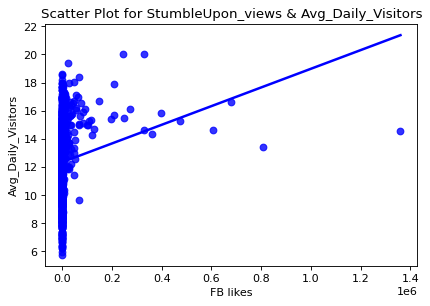

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     43.43
Date:                Sat, 21 May 2022   Prob (F-statistic):           5.85e-11
Time:                        17:56:56   Log-Likelihood:                -3673.3
No. Observations:                1685   AIC:                             7351.
Df Residuals:                    1683   BIC:                             7362.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.3452      0.05

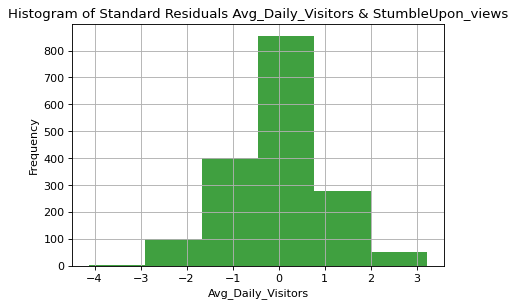

Shapiro Test
Statistics=0.995, p=0.000
Chi-squared test:
2.0998810461703518e-05


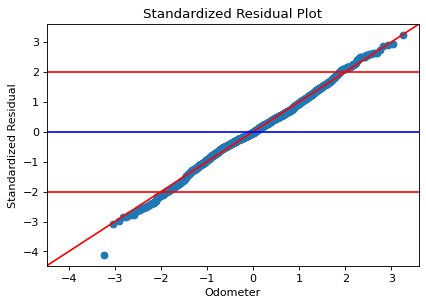

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  482
n1 =  843
n2 =  842

runs_exp =  843.4997032640949
stan_dev =  20.51827368001729
z =  -17.618426818049457
pval_z =  1.778831959358177e-69

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       2.858740
1       2.605673
2       3.229889
3       2.623006
6       2.918308
          ...   
1633   -2.354712
1635   -2.390417
1639   -2.864024
1682   -2.118034
1683   -2.858442
Name: SD, Length: 101, dtype: float64

Influential Observations 

[0.01330962 0.02363128 0.00065725 ... 0.00060172 0.00060172 0.00060172]
Influential Observations by hi = 

0       0.013310
1       0.023631
104     0.034012
118     0.009689
129     0.405636
135     0.005042
145     0.079849
159     0.100942
186     0.028111
260     0.008477
318     0.009511
388     0.013630
396     0.143038
573     0.023774
754     0.016451
954     0.048556
1638    0.003931
Name: hi, dtyp

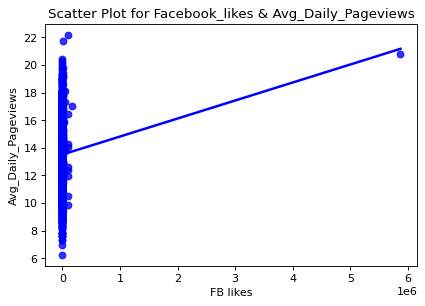

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     10.17
Date:                 Sat, 21 May 2022   Prob (F-statistic):            0.00145
Time:                         17:56:57   Log-Likelihood:                -3405.0
No. Observations:                 1483   AIC:                             6814.
Df Residuals:                     1481   BIC:                             6825.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.5031      0.0

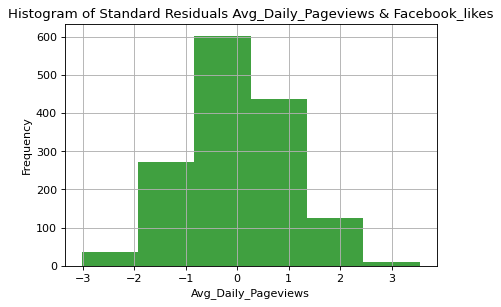

Shapiro Test
Statistics=0.998, p=0.202
Chi-squared test:
0.05135081460719003


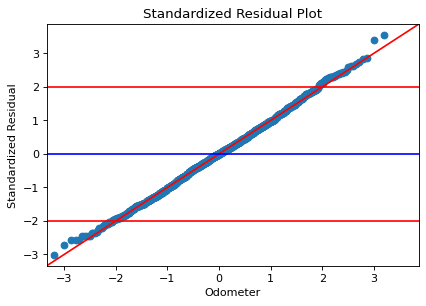

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  454
n1 =  742
n2 =  741

runs_exp =  742.4996628455833
stan_dev =  19.248363414968605
z =  -14.988269736284687
pval_z =  8.760585562106646e-51

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       3.547695
1       3.404929
2      -2.583751
3       2.594396
5       2.618226
          ...   
1347   -2.357807
1363    2.053449
1443   -2.443941
1457   -3.020223
1481   -2.738923
Name: SD, Length: 67, dtype: float64

Influential Observations 

[9.03595271e-04 6.76298160e-04 9.96563195e-01 ... 6.75094771e-04
 6.75094470e-04 6.75094168e-04]
Influential Observations by hi = 

2    0.996563
Name: hi, dtype: float64
MSE:  5.786734284345806
Standard errors:  2.405563194835215


Coefficient of determination:

SSR =  8570.153475116138
R2 =  0.00682325194505784


Coefficient of correlation:

r =  0.08260297782197547
t_critical =  1.961567075831078
t =  3.

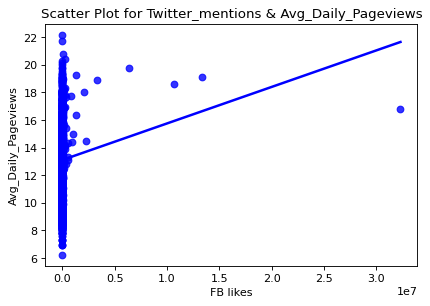

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.008
Model:                             OLS   Adj. R-squared:                  0.007
Method:                  Least Squares   F-statistic:                     16.72
Date:                 Sat, 21 May 2022   Prob (F-statistic):           4.50e-05
Time:                         17:56:58   Log-Likelihood:                -4822.4
No. Observations:                 2093   AIC:                             9649.
Df Residuals:                     2091   BIC:                             9660.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           13.1074   

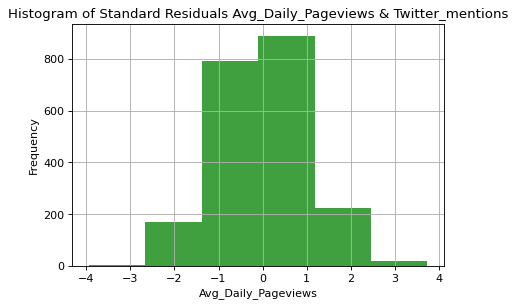

Shapiro Test
Statistics=0.998, p=0.003
Chi-squared test:
0.16998690540354677


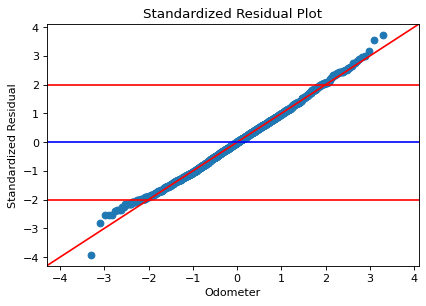

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  576
n1 =  1047
n2 =  1046

runs_exp =  1047.4997611084568
stan_dev =  22.86918541631109
z =  -20.61725210256798
pval_z =  1.9216768858845797e-94

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       3.732112
1       3.546821
2       3.167891
3       2.746348
6       2.761089
          ...   
1877   -2.175980
1901    2.201859
1944   -2.100706
1954   -2.391061
2021   -2.100706
Name: SD, Length: 92, dtype: float64

Influential Observations 

[0.0004784  0.0004782  0.00047819 ... 0.00047896 0.00047896 0.00047895]
Influential Observations by hi = 

15      0.008107
17      0.125970
26      0.029435
93      0.003534
174     0.743298
394     0.003962
1061    0.081580
Name: hi, dtype: float64
MSE:  5.877848330549557
Standard errors:  2.4244274232382286


Coefficient of determination:

SSR =  12290.580859179123
R2 =  0.007932527962441815


Coeffici

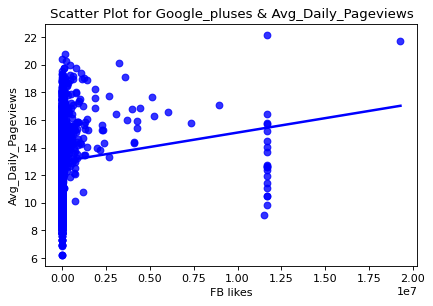

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.010
Model:                             OLS   Adj. R-squared:                  0.009
Method:                  Least Squares   F-statistic:                     27.55
Date:                 Sat, 21 May 2022   Prob (F-statistic):           1.65e-07
Time:                         17:56:58   Log-Likelihood:                -6395.5
No. Observations:                 2807   AIC:                         1.279e+04
Df Residuals:                     2805   BIC:                         1.281e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.0066      0.045 

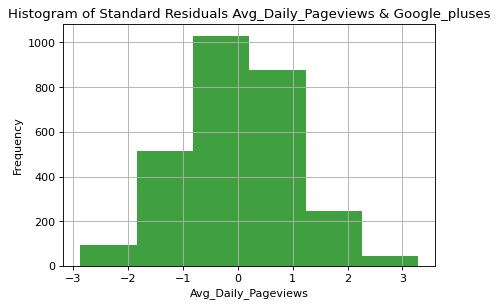

Shapiro Test
Statistics=0.998, p=0.002
Chi-squared test:
0.0034883874082016985


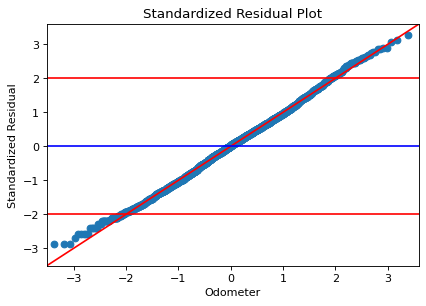

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  805
n1 =  1404
n2 =  1403

runs_exp =  1404.4998218738867
stan_dev =  26.4858402316993
z =  -22.634729222461353
pval_z =  1.972719053416035e-113

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       2.894115
1       2.089021
2       3.289100
3       2.790314
6       2.864583
          ...   
2647   -2.284353
2653   -2.125487
2725   -2.190013
2726   -2.112802
2758   -2.406201
Name: SD, Length: 129, dtype: float64

Influential Observations 

[0.03815619 0.10431389 0.0003565  ... 0.00036319 0.00036317 0.00036319]
Influential Observations by hi = 

0       0.038156
1       0.104314
114     0.010109
116     0.007289
133     0.003681
219     0.007658
221     0.004525
226     0.002748
301     0.022291
318     0.003001
628     0.038156
745     0.038156
855     0.005156
980     0.038156
1094    0.015117
1141    0.005513
1171    0.038156
1224    0.0

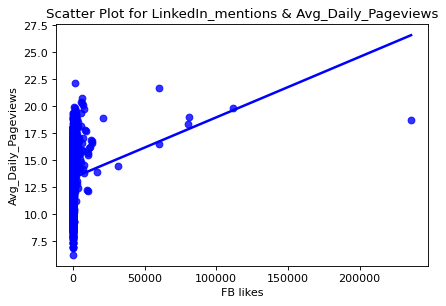

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.025
Model:                             OLS   Adj. R-squared:                  0.025
Method:                  Least Squares   F-statistic:                     53.86
Date:                 Sat, 21 May 2022   Prob (F-statistic):           3.08e-13
Time:                         17:56:59   Log-Likelihood:                -4698.9
No. Observations:                 2081   AIC:                             9402.
Df Residuals:                     2079   BIC:                             9413.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.3661

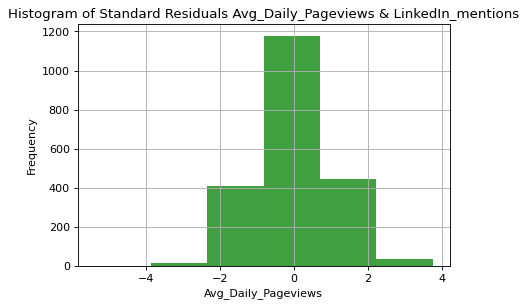

Shapiro Test
Statistics=0.998, p=0.005
Chi-squared test:
0.03105393519500043


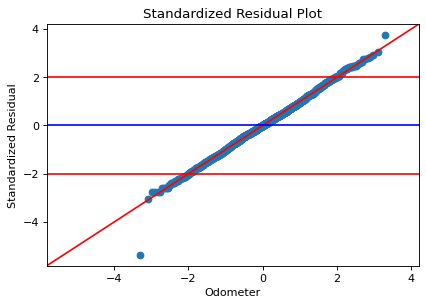

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  622
n1 =  1041
n2 =  1040

runs_exp =  1041.4997597308986
stan_dev =  22.80350059834276
z =  -18.396287794575965
pval_z =  1.4067837292332033e-75

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       3.757120
1       2.194782
2       3.062569
3       2.583333
6       2.749471
          ...   
1924    2.182259
1967   -2.486528
2026   -2.311436
2028   -2.786428
2078   -2.788241
Name: SD, Length: 103, dtype: float64

Influential Observations 

[0.00049181 0.03874921 0.00081865 ... 0.00048401 0.00048508 0.00048509]
Influential Observations by hi = 

1       0.038749
8       0.070448
17      0.005113
19      0.602273
28      0.135188
115     0.039137
397     0.010954
1073    0.069579
1683    0.003244
Name: hi, dtype: float64
MSE:  5.360809934210431
Standard errors:  2.315342293098459


Coefficient of determination:

SSR =  11145.123853223487
R2

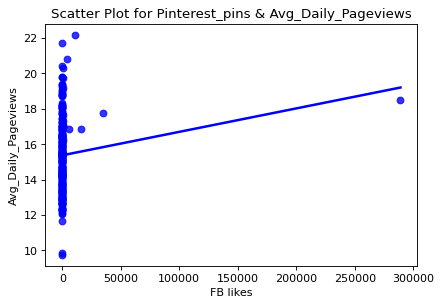

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.013
Model:                             OLS   Adj. R-squared:                  0.010
Method:                  Least Squares   F-statistic:                     3.499
Date:                 Sat, 21 May 2022   Prob (F-statistic):             0.0625
Time:                         17:56:59   Log-Likelihood:                -555.84
No. Observations:                  260   AIC:                             1116.
Df Residuals:                      258   BIC:                             1123.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         15.3708      0.1

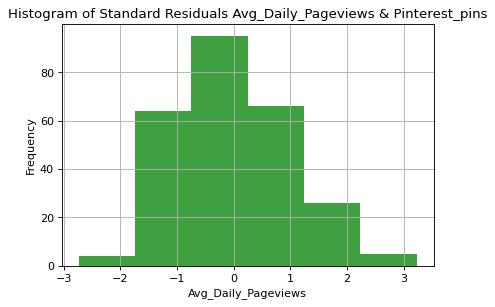

Shapiro Test
Statistics=0.985, p=0.009
Chi-squared test:
0.26649123391148


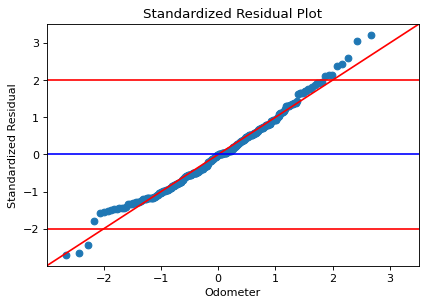

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  90
n1 =  130
n2 =  130

runs_exp =  131.0
stan_dev =  8.04667849171537
z =  -5.095270059840519
pval_z =  3.4824446815557084e-07

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0      3.232202
1      3.082079
2      2.615218
3      2.133990
5      2.154015
16     2.155971
41     2.389592
42    -2.461885
105    2.457521
160   -2.733457
220   -2.687177
Name: SD, dtype: float64

Influential Observations 

[0.00488826 0.00386805 0.00393496 0.0038574  0.00386906 0.00386942
 0.00386952 0.00386764 0.00386956 0.00386841 0.00386919 0.00385308
 0.00386956 0.00386867 0.00386877 0.00386952 0.0038661  0.00386956
 0.00386466 0.00386949 0.00386956 0.00386956 0.00386952 0.00386956
 0.00386949 0.00386629 0.00386956 0.00386933 0.00386949 0.00386956
 0.0038688  0.00386916 0.00386949 0.00386926 0.00386933 0.00386952
 0.00386936 0.00386956 0.00386956 0.00386946 0

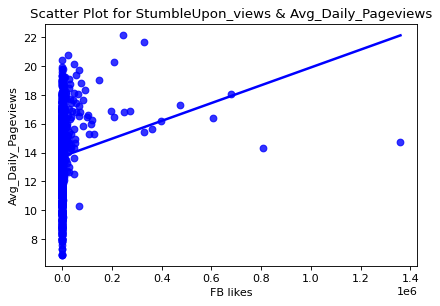

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.019
Model:                             OLS   Adj. R-squared:                  0.019
Method:                  Least Squares   F-statistic:                     32.99
Date:                 Sat, 21 May 2022   Prob (F-statistic):           1.10e-08
Time:                         17:57:00   Log-Likelihood:                -3786.4
No. Observations:                 1685   AIC:                             7577.
Df Residuals:                     1683   BIC:                             7588.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.7334

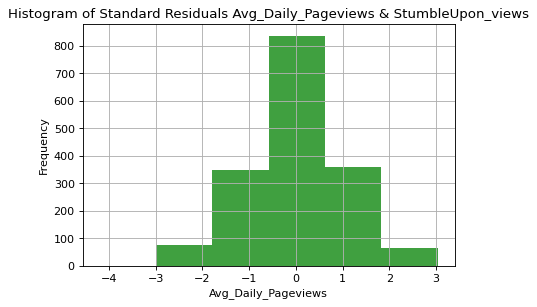

Shapiro Test
Statistics=0.996, p=0.000
Chi-squared test:
0.0023223224343292066


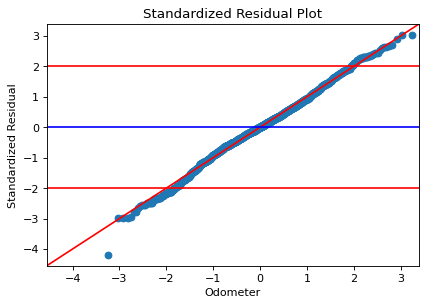

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  498
n1 =  843
n2 =  842

runs_exp =  843.4997032640949
stan_dev =  20.51827368001729
z =  -16.838634119622668
pval_z =  1.2713735188896967e-63

Since p-value < 0.05, we reject H0 and conclude randomness does not exist.
Outliers by SD = 

0       3.033349
1       2.624739
2       3.025010
3       2.448762
6       2.649267
          ...   
1633   -2.273853
1635   -2.497051
1639   -2.981220
1665   -2.010276
1683   -2.976871
Name: SD, Length: 102, dtype: float64

Influential Observations 

[0.01330962 0.02363128 0.00065725 ... 0.00060172 0.00060172 0.00060172]
Influential Observations by hi = 

0       0.013310
1       0.023631
104     0.034012
118     0.009689
129     0.405636
135     0.005042
145     0.079849
159     0.100942
186     0.028111
260     0.008477
318     0.009511
388     0.013630
396     0.143038
573     0.023774
754     0.016451
954     0.048556
1638    0.003931
Name: hi, dty

In [2]:
df = pd.read_excel('output.xlsx')
# display(df)

avg_dailys = ['Avg_Daily_Visitors', 'Avg_Daily_Pageviews']
media = ['Facebook_likes', 'Twitter_mentions', 'Google_pluses', 'LinkedIn_mentions', 'Pinterest_pins', 'StumbleUpon_views']

r_sqr_out_ln = {}

for ad in avg_dailys:
    for md in media:
        print("\n\n=================================== " + ad + " - " + md + " ===================================\n\n")
        
        

        """ ============================== data arrangement ============================== """

        fb = df[df[md].str.contains("-")==False]
        fb = fb[[ad,md]]
        fb.reset_index(inplace = True, drop = True)
        fb.dropna(inplace=True)
        fb[md] = fb[md].apply(value_to_int)
        fb[ad] = fb[ad].apply(value_to_int)
        fb[ad] = fb[ad].apply(value_to_ln)
        # display(fb)



        """ ============================== scatter plot ============================== """

        _ = sns.regplot(x=md, y=ad, data = fb, color = 'b', ci = None)
        plt.title('Scatter Plot for '+ md + ' & '+ ad)
        plt.xlabel('FB likes')
        plt.ylabel(ad)
        plt.show()



        """ ============================== regression summary table ============================== """

        # Fit regression model 
        fb_result = smf.ols(ad + ' ~ ' + md, data=fb).fit()
        # Inspect the results
        print(fb_result.summary())

        b1 = fb_result.params[1]
        b0 = fb_result.params[0]

        print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
        print(f"The coefficients are {b0:.4f} and {b1:.4f}")

        print(fb_result.summary())
        r_sqr_out_ln[ad + " of " + md] = float("{:.2f}".format(fb_result.rsquared))
        


        """ ============================== standardized residual ============================== """

        # studentized residual
        print("\n\nStandardized Residuals:\n")
        st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
        SD = data1[:, 10]
        mu = np.mean(SD)
        sigma = np.std(SD)
        print(SD)
        print('mu = ', mu)
        print('sigma = ', sigma)



        """ ============================== normality test ============================== """

        # histogram and Q-Q plot
        print("\n\nNormality test:\n")
        counts, bins, patches = plt.hist(SD, 6, density=False, facecolor='g', alpha=0.75)
        plt.xlabel(ad)
        plt.ylabel('Frequency')
        plt.title('Histogram of Standard Residuals ' + ad + ' & ' + md)
        plt.grid(True)
        bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
        plt.show()
        fig = sm.qqplot(SD, stats.norm, fit=True, line='45')

        # Shapiro test
        print('Shapiro Test')
        stat, p = stats.shapiro(SD)
        print('Statistics=%.3f, p=%.3f' % (stat, p))

        # chi^2 test
        chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
        print("Chi-squared test:")
        print(chi2_pval)



        """ ============================== Homoscedasticity & Heteroscedasticity ============================== """

        y_pre = data1[:, 2]
        plt.plot(y_pre, SD, 'o', color = 'gray')
        plt.axhline(y=0, color = 'blue')
        plt.axhline(y=2, color = 'red')
        plt.axhline(y=-2, color = 'red')
        plt.title('Standardized Residual Plot')
        plt.xlabel('Odometer')
        plt.ylabel('Standardized Residual')
        plt.show()



        """ ============================== runs test ============================== """

        Randomness(SD)



        """ ============================== outliers & influential ============================== """

        # outliers
        fb_c = pd.DataFrame(SD,columns = ['SD'])
        filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
        print("Outliers by SD = \n")
        print(fb_c['SD'].loc[filter])

        # influential
        print("\nInfluential Observations \n")
        x_data = fb[md].values
        y_data = fb[ad].values
        cov_mat1 = np.cov(y_data, x_data)
        x_data_bar = x_data.mean()
        data_nobs = len(x_data)
        h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
        print(h_val)
        fb_h = pd.DataFrame(h_val,columns = ['hi'])
        filter = (fb_h['hi'] > 6 / data_nobs )
        print("Influential Observations by hi = \n")
        print(fb_h['hi'].loc[filter])



        """ ============================== standard errors ============================== """

        s2_e = fb_result.mse_resid
        print('MSE: ', s2_e)
        s_e = fb_result.mse_resid ** 0.5
        print('Standard errors: ', s_e)



        """ ============================== coefficient of determination ============================== """

        print("\n\nCoefficient of determination:\n")
        SSR = fb_result.ssr
        # SST = SSR + SSE
        R2 = fb_result.rsquared
        print("SSR = ", SSR)
        print("R2 = ", R2)



        """ ============================== coefficient of correlation ============================== """

        print("\n\nCoefficient of correlation:\n")
        cor_mat = np.corrcoef(fb[[ad, md]].values, rowvar = False)
        n = fb[ad].shape[0]
        # print(n)
        r_t_value = c_of_c_test(cor_mat[1,0], n,0.05)





In [3]:
print("\n\nR Squareds:\n")
for item, amount in r_sqr_out_ln.items():  # dct.iteritems() in Python 2
    print("{} {}".format(item, amount))



R Squareds:

Avg_Daily_Visitors of Facebook_likes 0.01
Avg_Daily_Visitors of Twitter_mentions 0.01
Avg_Daily_Visitors of Google_pluses 0.02
Avg_Daily_Visitors of LinkedIn_mentions 0.03
Avg_Daily_Visitors of Pinterest_pins 0.01
Avg_Daily_Visitors of StumbleUpon_views 0.03
Avg_Daily_Pageviews of Facebook_likes 0.01
Avg_Daily_Pageviews of Twitter_mentions 0.01
Avg_Daily_Pageviews of Google_pluses 0.01
Avg_Daily_Pageviews of LinkedIn_mentions 0.03
Avg_Daily_Pageviews of Pinterest_pins 0.01
Avg_Daily_Pageviews of StumbleUpon_views 0.02
